In [34]:
import numpy as np
import h5py

# with h5py.File('/home/agah/FontCase/fonts.hdf5','r') as hf:
with h5py.File('..\\fonts.hdf5','r') as hf:
    print('List of arrays in this file: \n', hf.keys())
    data = hf.get('fonts')
    print(data)
    print(data.shape)
    imgC = data[43611,2,:,:]
    imgH = data[43611,7,:,:]
    
    smallDataSize = 1000

    As = data[:smallDataSize,0,:,:]
    Bs = data[:smallDataSize,1,:,:]
    
    AllAs = data[:,0,:,:]
    AllBs = data[:,1,:,:]

List of arrays in this file: 
 KeysView(<HDF5 file "fonts.hdf5" (mode r)>)
<HDF5 dataset "fonts": shape (56443, 62, 64, 64), type "|u1">
(56443, 62, 64, 64)


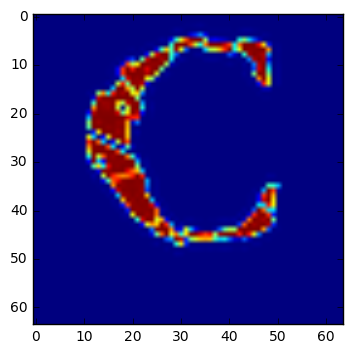

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(imgC)

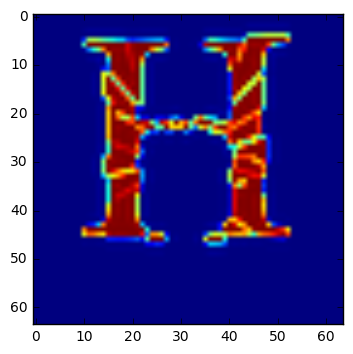

In [3]:
plt.imshow(imgH)

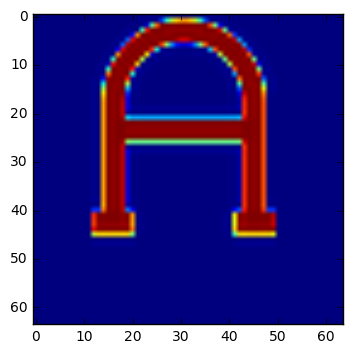

In [4]:
plt.imshow(As[0])

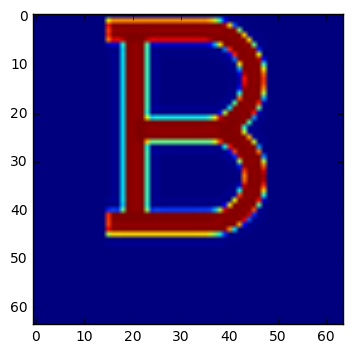

In [5]:
plt.imshow(Bs[0])

In [6]:
print(As.shape)
print(Bs.shape)

(1000, 64, 64)
(1000, 64, 64)


In [7]:
import numpy

def shuffle_in_unison(a, b):
    assert len(a) == len(b)
    shuffled_a = numpy.empty(a.shape, dtype=a.dtype)
    shuffled_b = numpy.empty(b.shape, dtype=b.dtype)
    permutation = numpy.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

In [8]:
As_reshaped = As.reshape((smallDataSize, 64*64))
print(As_reshaped.shape)

Bs_reshaped = Bs.reshape((smallDataSize, 64*64))
print(Bs_reshaped.shape)

As_reshaped, Bs_reshaped = shuffle_in_unison(As_reshaped, Bs_reshaped)


(1000, 4096)
(1000, 4096)


In [9]:
training_size = (int)(smallDataSize * 0.90)
test_size = smallDataSize - training_size

print(training_size)
print(test_size)
print(training_size + test_size == smallDataSize)
As_reshaped_training = As_reshaped[:training_size, :]
Bs_reshaped_training = Bs_reshaped[:training_size, :]

As_reshaped_test = As_reshaped[training_size:, :]
Bs_reshaped_test = Bs_reshaped[training_size:, :]

print(As_reshaped_training.shape)
print(Bs_reshaped_training.shape)
print(As_reshaped_test.shape)
print(Bs_reshaped_test.shape)

900
100
True
(900, 4096)
(900, 4096)
(100, 4096)
(100, 4096)


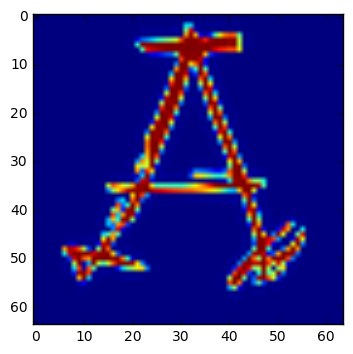

In [10]:
plt.imshow(As_reshaped_training[0,:].reshape((64,64)))

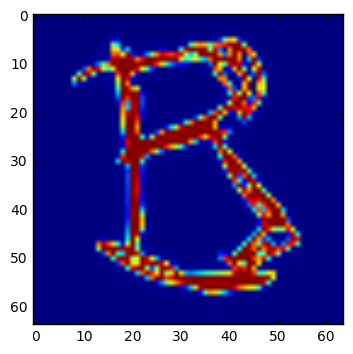

In [11]:
plt.imshow(Bs_reshaped_training[0,:].reshape((64,64)))

In [12]:
print(numpy.unique(As_reshaped_training[0,:]))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  19  21  22  23  24  25  26  27  29  30  31  32  33  34  35  37  38  39
  40  41  42  44  45  46  47  48  50  51  52  53  54  55  56  57  58  59
  61  62  63  64  65  66  67  68  70  72  73  74  76  77  78  80  82  83
  84  85  87  88  89  90  91  93  95  96  97  98 100 101 103 104 105 106
 108 109 110 111 112 113 114 115 117 119 120 121 123 124 125 126 127 128
 129 131 133 135 136 138 139 140 141 142 143 144 146 147 149 150 151 152
 153 154 155 156 159 160 161 163 164 165 166 167 168 169 170 171 172 173
 174 176 178 181 182 184 185 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 222 223 224 226 227 228 229 230 231 233 234 235 236 237
 238 239 240 241 243 244 245 246 247 248 249 250 251 252 253 254 255]


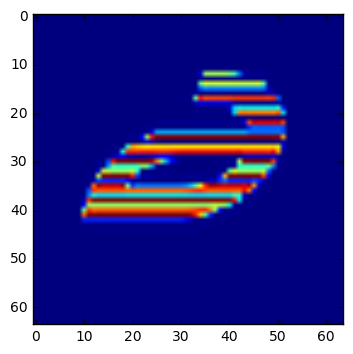

In [13]:
plt.imshow(As_reshaped_test[0,:].reshape((64,64)))

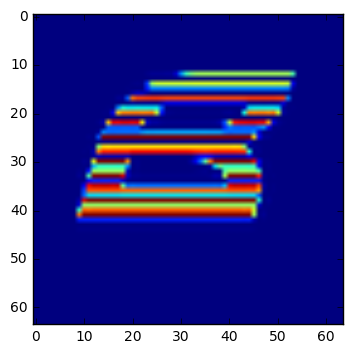

In [14]:
plt.imshow(Bs_reshaped_test[0,:].reshape((64,64)))

In [15]:
from sklearn import svm

import sklearn

class VectorRegression():
    def __init__(self):
        self.clf = svm.SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='auto',
                            kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

    def fit(self, X, y):
        n, m = y.shape
        # Fit a separate regressor for each column of y
        self.estimators_ = [sklearn.base.clone(self.clf).fit(X, y[:, i])
                               for i in range(m)]
        return self

    def predict(self, X):
        # Join regressors' predictions
        res = [est.predict(X)[:, np.newaxis] for est in self.estimators_]
        return np.hstack(res)
    
class SingleVectorRegression():
    def __init__(self):
        self.clf = svm.SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='auto',
                            kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

    def fit(self, X, y):
        n = y.shape
        # Fit a separate regressor for each column of y
        self.estimator = self.clf.fit(X, y)
        return self

    def predict(self, X):
        # Join regressors' predictions
        res = self.estimator.predict(X)
        return np.hstack(res)
    
class SingleClassifi():
    def __init__(self):
        self.clf = svm.SVD(C=300, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='auto',
                            kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

    def fit(self, X, y):
        n = y.shape
        # Fit a separate regressor for each column of y
        self.estimator = self.clf.fit(X, y)
        return self

    def predict(self, X):
        # Join regressors' predictions
        res = self.estimator.predict(X)
        return np.hstack(res)

In [16]:
import pickle

def processBit(bitIndex, keepModel = True, reportTwo = True):

    vr = SingleVectorRegression()
    model = vr.fit(As_reshaped_training, Bs_reshaped_training[:,bitIndex]) 
    
    if keepModel:
        output = open('data{0}.pkl'.format(bitIndex), 'wb')
        pickle.dump(model, output)
        output.close()
    
    pred = vr.predict(As_reshaped_test)
    predList = [int(v) for v in pred]
    result = (predList == Bs_reshaped_test[:,bitIndex])

    falseList = filter(lambda x:  not x, result)
    trueList = filter(lambda x: x, result)

    falseCount = len(list(falseList))
    correctCount = len(list(trueList))

    assert(falseCount + correctCount == test_size)
    errorRate = falseCount * 1.0 / test_size
    correctRate = correctCount * 1.0 / test_size

    if reportTwo:
        print("Bit {1}, error rate: {0}".format(errorRate * 100.00, bitIndex))
        print("Bit {1}, Correct rate: {0}".format(correctRate * 100.00, bitIndex))

    return errorRate


In [17]:
%%time
processBit(0)

Bit 0, error rate: 2.0
Bit 0, Correct rate: 98.0
Wall time: 4.84 s


0.02

In [18]:
%%time
processBit(1024)

Bit 1024, error rate: 5.0
Bit 1024, Correct rate: 95.0
Wall time: 5.01 s


0.05

In [19]:
%%time
processBit(2048)

Bit 2048, error rate: 7.000000000000001
Bit 2048, Correct rate: 93.0
Wall time: 4.96 s


0.07

In [20]:
%%time
processBit(3000)

Bit 3000, error rate: 3.0
Bit 3000, Correct rate: 97.0
Wall time: 4.95 s


0.03

In [21]:
%%time
processBit(4095)

Bit 4095, error rate: 0.0
Bit 4095, Correct rate: 100.0
Wall time: 4.81 s


0.0

In [22]:
%%time

iteration = 1024
erates = np.zeros(iteration)
for bi in range(iteration):
    erates[bi] = processBit(bi, False, False) * 100
    if bi % 100 == 0:
        print(bi, erates[bi])

0 2.0
100 36.0
200 7.0
300 22.0
400 43.0
500 5.0
600 98.0
700 1.0
800 93.0
900 5.0
1000 100.0
Wall time: 1h 20min 59s


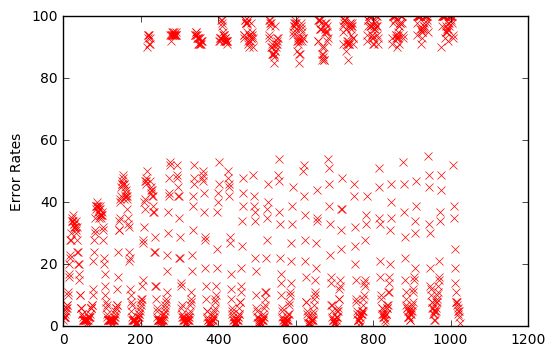

In [23]:
import matplotlib.pyplot as plt
plt.plot(erates, 'rx')
plt.ylabel('Error Rates')
plt.show()

In [24]:
np.set_printoptions(threshold=np.inf)
print(erates)

[   2.    3.    3.    3.    3.    3.    4.    6.    5.    6.    7.    7.
   10.   11.   16.   17.   20.   22.   23.   28.   28.   30.   35.   34.
   34.   34.   36.   33.   32.   33.   32.   32.   34.   30.   31.   32.
   28.   24.   24.   20.   20.   17.   15.   10.   10.    6.    6.    6.
    4.    4.    3.    2.    2.    2.    2.    2.    2.    2.    2.    2.
    2.    2.    1.    0.    2.    3.    3.    3.    3.    3.    4.    6.
    6.    6.    7.    7.   10.   12.   21.   24.   28.   30.   31.   35.
   39.   39.   38.   39.   40.   39.   37.   37.   38.   35.   38.   39.
   36.   36.   35.   36.   36.   37.   31.   32.   28.   20.   22.   17.
   13.   10.    8.    6.    7.    4.    3.    2.    2.    2.    2.    2.
    2.    2.    2.    2.    2.    2.    1.    0.    2.    2.    2.    2.
    3.    3.    4.    5.    6.    6.    7.    7.   12.   16.   24.   31.
   31.   34.   35.   40.   41.   42.   45.   46.   47.   46.   48.   49.
   46.   46.   41.   45.   42.   43.   44.   42.   

SVD

In [25]:
# %%time

# print(AllAs.shape)
# print(AllBs.shape)

# AllAs_reshaped = AllAs.reshape(((AllAs.shape)[0], 64*64))
# print(AllAs_reshaped.shape)

# AllBs_reshaped = AllBs.reshape(((AllBs.shape)[0], 64*64))
# print(AllBs_reshaped.shape)


In [26]:
# def doPCA(data, components):
#     from sklearn.decomposition import PCA
#     pca = PCA(n_components=components)
#     pca.fit(data)
#     return pca

In [27]:
# pca = doPCA(AllAs_reshaped, 1024)
# print(pca.explained_variance_ratio_)

In [28]:
# first_pca = pca.components_[0]
# second_pca = pca.components_[1]

# print(first_pca.shape)

In [29]:
# transformed_As = pca.transform(AllAs_reshaped)
# print(transformed_As.shape)

In [30]:
# print(As_U.shape)
# print(As_s.shape)
# print(As_V.shape)

# k = 1024
# As_S = np.diag(As_s[:k])
# As_reconst = np.dot(As_U[:,:k], np.dot(As_S, As_V))print(As_reconst.shape)

In [31]:
# As_U, As_s, As_V = np.linalg.svd(AllAs_reshaped, full_matrices=False)

Clustering

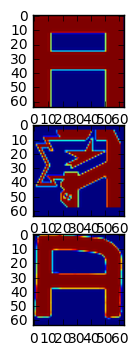

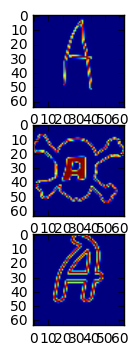

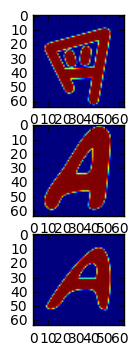

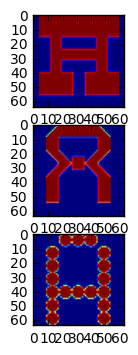

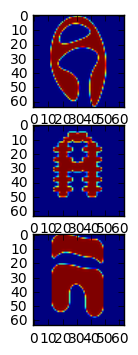

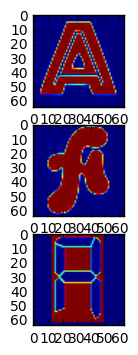

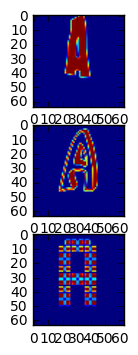

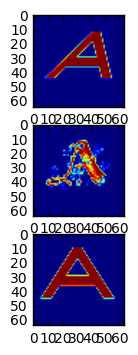

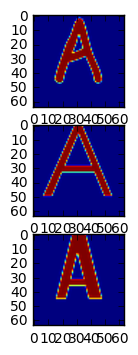

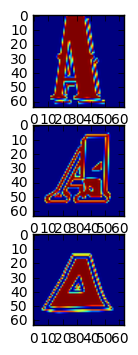

In [58]:
from sklearn.cluster import KMeans
import numpy as np
import random

def clusterAndRepresent(numberOfCluster, data, imageCount):
    kmeans = KMeans(n_clusters=numberOfCluster, random_state=0).fit(data)
    for i in range(numberOfCluster):
        inds = np.where(kmeans.labels_ == i)[0].tolist()
        randInds = random.sample(inds, imageCount)
        _, axarr = plt.subplots(imageCount)
        counter = 0
        for j in randInds:
            img = data[j,:].reshape((64,64))
            axarr[counter].imshow(img)
            counter += 1

    plt.show()
#     print(kmeans.cluster_centers_)
    
clusterAndRepresent(10, As_reshaped_training, 3)
# print(kmeans.labels_)
# kmeans.predict(Bs_reshaped_test[:,0])
# array([0, 1], dtype=int32)
# >>> kmeans.cluster_centers_

Hierarchical Clustering

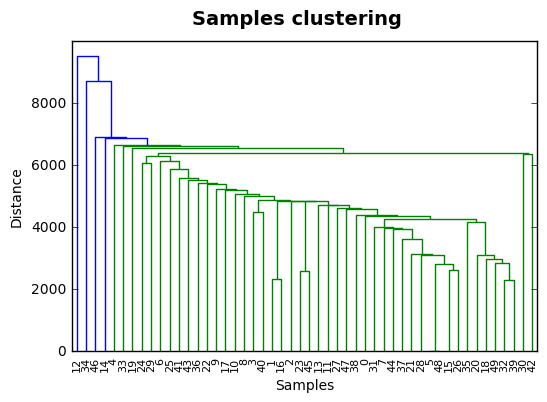

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram

data_dist = pdist(As_reshaped_training[:50]) # computing the distance
data_link = linkage(data_dist) # computing the linkage

dendrogram(data_link,labels=data.dtype.names)
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.suptitle('Samples clustering', fontweight='bold', fontsize=14);

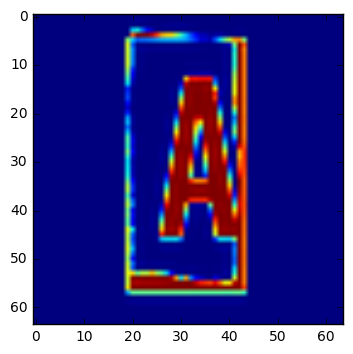

In [70]:
plt.imshow(As_reshaped_training[1,:].reshape((64,64)))

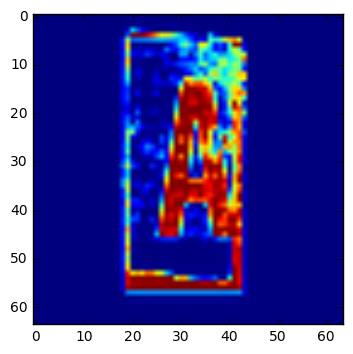

In [71]:
plt.imshow(As_reshaped_training[16,:].reshape((64,64)))

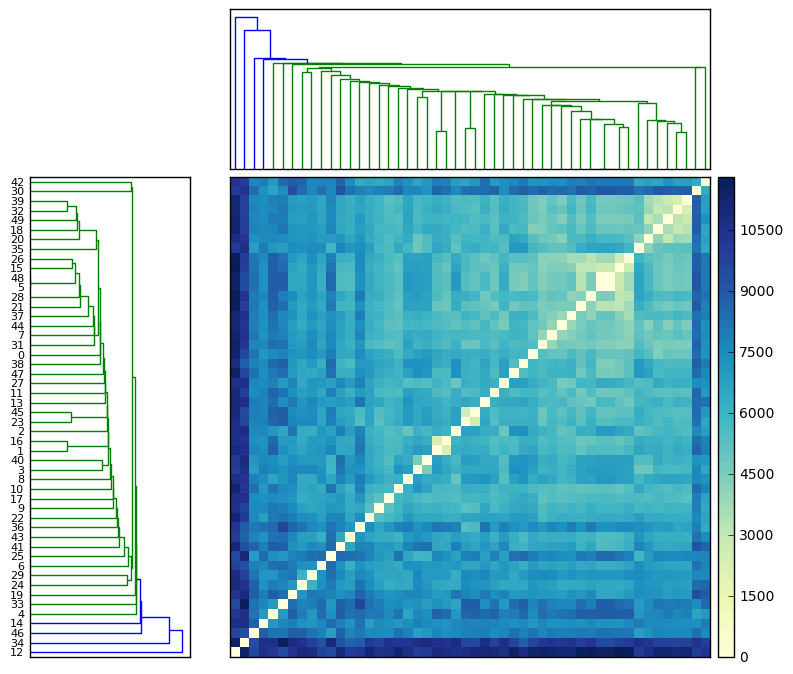

In [72]:
#First dendrogram.
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_axes([0.05,0.1,0.2,0.6])
Y = linkage(data_dist, method='single')
Z1 = dendrogram(Y, orientation='right',labels=data.dtype.names)
ax1.set_xticks([])

#Second dendrogram.
ax2 = fig.add_axes([0.3,0.71,0.6,0.2])
Z2 = dendrogram(Y)
ax2.set_xticks([])
ax2.set_yticks([])

axmatrix = fig.add_axes([0.3,0.1,0.6,0.6])
idx1 = Z1['leaves']
idx2 = Z2['leaves']
D = squareform(data_dist)
D = D[idx1,:]
D = D[:,idx2]
im = axmatrix.matshow(D, aspect='auto', origin='lower', cmap=plt.cm.YlGnBu)
axmatrix.set_xticks([])
axmatrix.set_yticks([])

# Plot colorbar.
axcolor = fig.add_axes([0.91,0.1,0.02,0.6])
plt.colorbar(im, cax=axcolor)